In [1]:
import pandas as pd
from scipy import stats
import numpy as np

PATH = "result/vqa/detailed_per_image_question.csv"
df = pd.read_csv(PATH)

# 1) (participant, system, image_path, target_image_id, rating) 단위로 accuracy 계산
agg_df = (
    df.groupby(["participant", "system", "image_path", "target_image_id", "rating"])["is_correct"]
      .agg(total="count", correct="sum")
      .reset_index()
)
agg_df["accuracy"] = agg_df["correct"] / agg_df["total"]

# 2) 각 (participant, system)에서 accuracy가 가장 높은 행만 선택
idx = agg_df.groupby(["participant", "system"])["accuracy"].idxmax()
best = agg_df.loc[idx].reset_index(drop=True)

# (선택) system 라벨 매핑: 원하면 사용
# label_map = {"system1": "Baseline", "system2": "OOPT"}
# best["system"] = best["system"].map(label_map).fillna(best["system"])

# 3) 참가자별로 두 시스템 accuracy를 나란히 피벗
pivot = best.pivot(index="participant", columns="system", values="accuracy")

# 두 시스템 값이 모두 있는 참가자만 사용
pivot = pivot.dropna(axis=0, how="any")

# 4) 요약 통계
summary = pivot.agg(["mean", "std", "count"])
print("=== Per-system summary (using each participant's best image accuracy) ===")
print(summary)
print()

# 5) 시스템 간 짝지은 비교 (paired)
# 시스템 이름이 무엇이든, 컬럼 2개만 있다고 가정
sys_cols = list(pivot.columns)
a, b = pivot[sys_cols[0]].values, pivot[sys_cols[1]].values

# Paired t-test
t_stat, p_val = stats.ttest_rel(a, b, nan_policy="omit")

# Wilcoxon (비모수, 동점/표본수 이슈 있으면 실패 가능)
try:
    w_stat, w_p = stats.wilcoxon(a, b, zero_method="wilcox", alternative="two-sided", method="auto")
except Exception as e:
    w_stat, w_p = np.nan, np.nan

# 효과크기 (paired Cohen's d = mean(diff)/std(diff))
diff = b - a
cohens_d = diff.mean() / diff.std(ddof=1) if diff.std(ddof=1) > 0 else np.nan

print(f"=== Paired comparison between systems: {sys_cols[0]} vs {sys_cols[1]} ===")
print(f"Paired t-test: t={t_stat:.3f}, p={p_val:.6g}")
print(f"Wilcoxon signed-rank: W={w_stat}, p={w_p if not np.isnan(w_p) else 'NA'}")
print(f"Effect size (Cohen's d for paired): {cohens_d:.3f}")
print()

# 6) 참가자별 차이표(보기 좋게)
result_table = pivot.copy()
result_table["diff (B - A)"] = result_table[sys_cols[1]] - result_table[sys_cols[0]]
print("=== Participant-level best accuracies and difference ===")
print(result_table)


=== Per-system summary (using each participant's best image accuracy) ===
system    system1    system2
mean     0.739155   0.745273
std      0.111687   0.076036
count   12.000000  12.000000

=== Paired comparison between systems: system1 vs system2 ===
Paired t-test: t=-0.155, p=0.879389
Wilcoxon signed-rank: W=35.0, p=0.791015625
Effect size (Cohen's d for paired): 0.045

=== Participant-level best accuracies and difference ===
system        system1   system2  diff (B - A)
participant                                  
P1           0.774194  0.827586      0.053393
P10          0.645161  0.793103      0.147942
P11          0.896552  0.774194     -0.122358
P12          0.580645  0.793103      0.212458
P2           0.838710  0.758621     -0.080089
P3           0.689655  0.741935      0.052280
P4           0.758621  0.806452      0.047831
P5           0.827586  0.548387     -0.279199
P6           0.741935  0.689655     -0.052280
P7           0.806452  0.758621     -0.047831
P8           0.

In [22]:
agg_df.to_csv("result/vqa/agg_per_participant_system_image.csv", index=False)

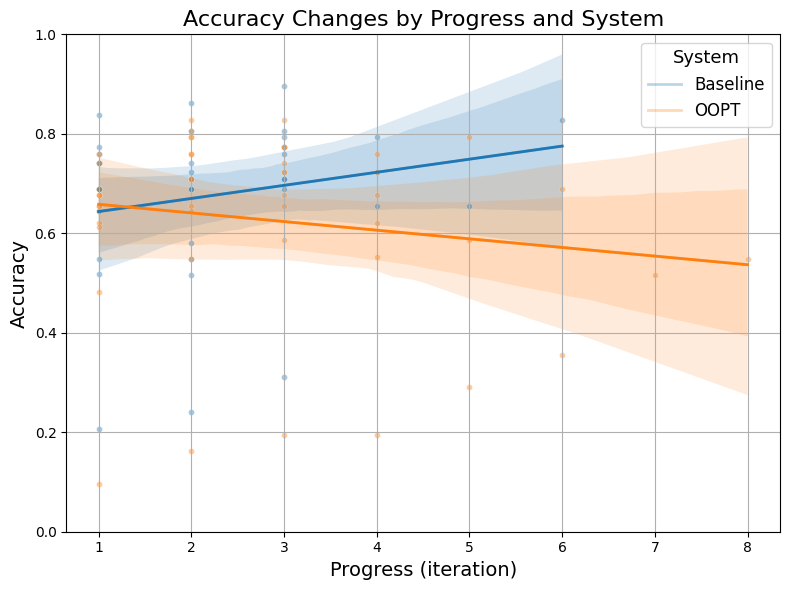

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PATH = "result/vqa/detailed_per_image_question.csv"
raw = pd.read_csv(PATH)

# 1) 이미지(생성 1회) 단위 accuracy 집계
#    groupby 기준: participant, system, image_path (필요시 target_image_id 포함 가능)
img_acc = (
    raw.groupby(["participant", "system", "image_path"], sort=False)["is_correct"]
       .agg(total="count", correct="sum")
       .reset_index()
)
img_acc["accuracy"] = img_acc["correct"] / img_acc["total"]

# 2) 생성 순서(gen_index) 결정
#    - 있으면 사용: gen_index, image_timestamp 등
#    - 없으면 각 (participant, system) 그룹 내에서 image_path 등장 순서로 부여
order_col = None
for cand in ["gen_index", "image_timestamp", "created_at", "timestamp"]:
    if cand in raw.columns:
        order_col = cand
        break

if order_col is not None:
    # 이미지 단위로 order 컬럼을 합치기 위해, 각 image_path의 대표 order를 뽑음
    # (질문 단위 raw에서 같은 image_path의 order 값이 동일하다고 가정)
    order_rep = (
        raw.drop_duplicates(["participant","system","image_path"])
           [["participant","system","image_path", order_col]]
    )
    img_acc = img_acc.merge(order_rep, on=["participant","system","image_path"], how="left")
else:
    # 그룹 내 최초 등장 순서로 gen_index 부여
    img_acc["gen_index"] = (
        img_acc.groupby(["participant","system"], sort=False)
               .cumcount() + 1
    )
    order_col = "gen_index"

# 3) (participant, system)별로 '끝까지' 진행(progress=1..N)과 accuracy 시퀀스 구축
def build_progress_df_full_from_img(img_df, participant_col="participant", system_col="system",
                                    acc_col="accuracy", order_col="gen_index"):
    rows = []
    for (pid, sys_name), sub in img_df.groupby([participant_col, system_col], sort=False):
        sub = sub.copy()
        # 정렬
        if order_col in sub.columns:
            # 숫자/시간 모두 대응 (문자열 시간일 경우도 pandas가 정렬 가능)
            sub = sub.sort_values(by=order_col, kind="stable")
        else:
            # 혹시 몰라 안전장치
            sub = sub.reset_index(drop=False).sort_values("index", kind="stable")
        # 끝까지 사용
        for i, acc in enumerate(sub[acc_col].tolist(), start=1):
            rows.append({"participant": pid, "system": sys_name, "progress": i, "accuracy": acc})
    return pd.DataFrame(rows)

df_viz = build_progress_df_full_from_img(img_acc, order_col=order_col)

# 4) 시각화
plt.figure(figsize=(8, 6))

# 시스템 라벨/색상
palette = {"Baseline": "#1f77b4", "OOPT": "#ff7f0e"}
name_map = {"system1": "Baseline", "system2": "OOPT"}

for raw_sys, pretty_name in name_map.items():
    color = palette[pretty_name]
    sub = df_viz[df_viz["system"] == raw_sys]

    # 바깥 99.5% CI
    sns.regplot(
        data=sub, x="progress", y="accuracy", scatter=False,
        ci=99.5,
        line_kws={"lw": 2, "alpha": 0.30, "color": color},
        color=color, label=pretty_name
    )
    # 안쪽 95% CI
    sns.regplot(
        data=sub, x="progress", y="accuracy", scatter=False,
        ci=95,
        line_kws={"lw": 2, "alpha": 1.00, "color": color},
        color=color
    )

# (선택) 산점도도 보려면 주석 해제
for raw_sys, pretty_name in name_map.items():
    color = palette[pretty_name]
    sub = df_viz[df_viz["system"] == raw_sys]
    sns.scatterplot(data=sub, x="progress", y="accuracy", s=18, alpha=0.4, color=color)

plt.title("Accuracy Changes by Progress and System", fontsize=16)
plt.xlabel("Progress (iteration)", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1)  # accuracy 범위 고정
plt.grid(True)
plt.legend(title="System", fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('accuracy ~ progress * C(system)', data=df_viz).fit()
anova_result = anova_lm(model, typ=2)
p_value = anova_result.loc['progress:C(system)', 'PR(>F)']
print(f"p-value: {p_value}")

p-value: 0.1122381762224451


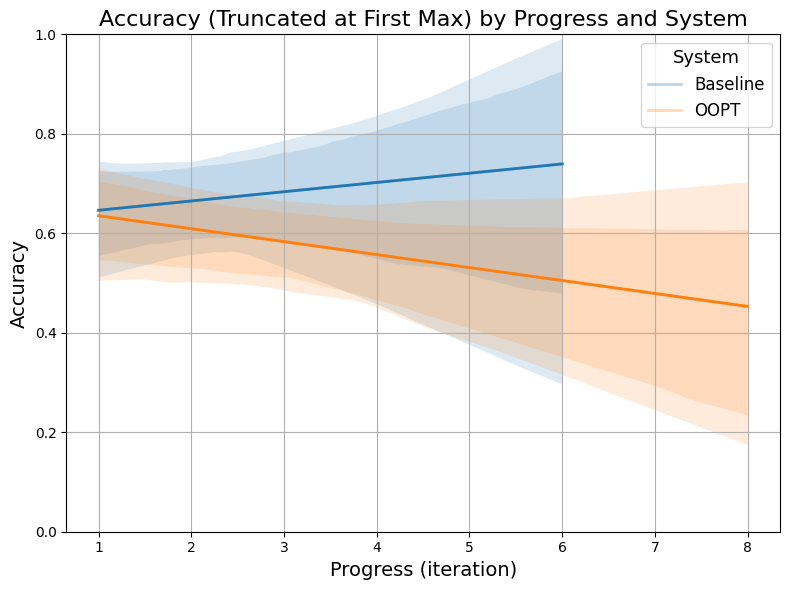

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PATH = "result/vqa/detailed_per_image_question.csv"
raw = pd.read_csv(PATH)

# 1) 이미지 단위 accuracy 집계
img_acc = (
    raw.groupby(["participant", "system", "image_path"], sort=False)["is_correct"]
       .agg(total="count", correct="sum")
       .reset_index()
)
img_acc["accuracy"] = img_acc["correct"] / img_acc["total"]

# 2) 생성 순서 결정 (gen_index / timestamp 있으면 사용, 없으면 등장 순서)
order_col = None
for cand in ["gen_index", "image_timestamp", "created_at", "timestamp"]:
    if cand in raw.columns:
        order_col = cand
        break

if order_col is not None:
    order_rep = (
        raw.drop_duplicates(["participant","system","image_path"])
           [["participant","system","image_path", order_col]]
    )
    img_acc = img_acc.merge(order_rep, on=["participant","system","image_path"], how="left")
else:
    img_acc["gen_index"] = (
        img_acc.groupby(["participant","system"], sort=False)
               .cumcount() + 1
    )
    order_col = "gen_index"

# 3) 각 그룹별로 '최대 accuracy 첫 등장 시점까지' 자르기
def build_progress_df_until_max(img_df, participant_col="participant", system_col="system",
                                acc_col="accuracy", order_col="gen_index"):
    rows = []
    for (pid, sys_name), sub in img_df.groupby([participant_col, system_col], sort=False):
        sub = sub.copy()
        sub = sub.sort_values(by=order_col, kind="stable")
        accs = sub[acc_col].tolist()
        if len(accs) == 0:
            continue
        max_idx = int(np.argmax(accs))  # 첫 최대값 위치
        accs = accs[:max_idx+1]         # 그 시점까지만 사용
        for i, acc in enumerate(accs, start=1):
            rows.append({"participant": pid, "system": sys_name,
                         "progress": i, "accuracy": acc})
    return pd.DataFrame(rows)

df_viz = build_progress_df_until_max(img_acc, order_col=order_col)

# 4) 시각화
plt.figure(figsize=(8, 6))

palette = {"Baseline": "#1f77b4", "OOPT": "#ff7f0e"}
name_map = {"system1": "Baseline", "system2": "OOPT"}

for raw_sys, pretty_name in name_map.items():
    color = palette[pretty_name]
    sub = df_viz[df_viz["system"] == raw_sys]

    # 바깥 99.5% CI
    sns.regplot(
        data=sub, x="progress", y="accuracy", scatter=False,
        ci=99.5,
        line_kws={"lw": 2, "alpha": 0.30, "color": color},
        color=color, label=pretty_name
    )
    # 안쪽 95% CI
    sns.regplot(
        data=sub, x="progress", y="accuracy", scatter=False,
        ci=95,
        line_kws={"lw": 2, "alpha": 1.00, "color": color},
        color=color
    )

plt.title("Accuracy (Truncated at First Max) by Progress and System", fontsize=16)
plt.xlabel("Progress (iteration)", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(title="System", fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('accuracy ~ progress * C(system)', data=df_viz).fit()
anova_result = anova_lm(model, typ=2)
p_value = anova_result.loc['progress:C(system)', 'PR(>F)']
print(f"p-value: {p_value}")

p-value: 0.18222538138964156


In [42]:
import statsmodels.formula.api as smf
model = smf.mixedlm("accuracy ~ progress * C(system)",
                    df_viz, groups=df_viz["participant"])
result = model.fit()
print(result.summary())


                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       accuracy
No. Observations:       60            Method:                   REML    
No. Groups:             12            Scale:                    0.0067  
Min. group size:        2             Log-Likelihood:           37.7536 
Max. group size:        14            Converged:                Yes     
Mean group size:        5.0                                             
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.513    0.055  9.352 0.000  0.406  0.621
C(system)[T.system2]           0.064    0.038  1.670 0.095 -0.011  0.140
progress                       0.111    0.014  7.933 0.000  0.083  0.138
progress:C(system)[T.system2] -0.071    0.015 -4.889 0.000 -0.100 -0.

In [33]:
import pandas as pd

PATH = "result/vqa/detailed_per_image_question.csv"
df = pd.read_csv(PATH)

# 0) 제외할 질문 리스트
exclude_questions = [
    "Is the woman smiling?",
    "Are the adults smiling while the girl looks more serious?",
    "Does the girl look more serious or thoughtful than the adults?",
    "Does the man have a neutral, purposeful expression?",
    "Does the man in the green shirt have a neutral expression?",
    "Are the group members generally arranged side by side?",
    "Is the man in the green shirt walking in a laid-back manner?"
]

# (선택) 공백/케이스 이슈 대비
df["question"] = df["question"].astype(str).str.strip()

# 1) 위 질문들 제외
df_filt = df[~df["question"].isin(exclude_questions)].copy()

# 2) (participant, system, image_path, target_image_id, rating) 단위로 accuracy 계산
agg_df = (
    df_filt.groupby(["participant", "system", "image_path", "target_image_id", "rating"])["is_correct"]
           .agg(total="count", correct="sum")
           .reset_index()
)
agg_df["accuracy"] = agg_df["correct"] / agg_df["total"]

# 3) 각 (participant, system)에서 accuracy가 가장 높은 행만 선택
idx = agg_df.groupby(["participant", "system"])["accuracy"].idxmax()
best = agg_df.loc[idx].reset_index(drop=True)



  participant   system                                  image_path  \
0          P1  system1   ./output/P1/2025-08-24_11-33-19/image.png   
1          P1  system2   ./output/P1/2025-08-24_12-04-10/image.png   
2         P10  system1  ./output/P10/2025-08-21_09-44-58/image.png   
3         P10  system2  ./output/P10/2025-08-21_10-08-07/image.png   
4         P11  system1  ./output/P11/2025-08-23_09-36-41/image.png   

  target_image_id  rating  total  correct  accuracy  
0         target2     6.0     28       22  0.785714  
1         target1     4.0     25       23  0.920000  
2         target2     6.0     28       17  0.607143  
3         target1     4.0     25       20  0.800000  
4         target1     1.0     25       22  0.880000  


In [20]:
# best에서 필요한 key만 추출
best_keys = best[["participant", "system", "image_path", "target_image_id", "rating"]]

# 원본 df에서 best에 해당하는 행만 남기기
df_best = df.merge(best_keys, on=["participant", "system", "image_path", "target_image_id", "rating"], how="inner")

# 질문 단위로 시스템별 정답률 집계
q_acc = (
    df_best.groupby(["question", "system"])["is_correct"]
    .mean()
    .reset_index()
    .pivot(index="question", columns="system", values="is_correct")
)

# system1 - system2 차이
q_acc["diff"] = q_acc["system1"] - q_acc["system2"]

# 차이 큰 순서대로 정렬
q_acc_sorted = q_acc.sort_values("diff", ascending=False)

q_acc_sorted

system,system1,system2,diff
question,,,
Is the man in the green shirt wearing beige shorts?,1.000000,0.500000,0.500000
Is the woman with the camera wearing a mint-green summer dress?,0.666667,0.166667,0.500000
Is the man in the green shirt walking in a laid-back manner?,1.000000,0.666667,0.333333
Is the man in the green shirt standing casually with his hands in his pockets?,1.000000,0.666667,0.333333
Is the man wearing black sandals?,0.500000,0.166667,0.333333
Is the man with the map wearing a white button-up shirt?,0.833333,0.500000,0.333333
Does the girl look more serious or thoughtful than the adults?,0.333333,0.000000,0.333333
Is the woman with the camera raising a small camera to take a photo?,0.833333,0.666667,0.166667
Is the man with the map wearing beige trousers?,0.833333,0.666667,0.166667


In [24]:
# 1) system1 - system2 차이가 큰 상위 5개 질문
top5_questions = q_acc_sorted.head(5).index.tolist()

# 2) system2가 틀린(No) 경우의 image_path 추출
system2_wrong_images = (
    df_best[
        (df_best["system"] == "system2")
        & (df_best["question"].isin(top5_questions))
        & (df_best["is_correct"] == 0)
    ][["question", "image_path"]]
    .drop_duplicates()
)

system2_wrong_images

,question,image_path
46,Is the man wearing black sandals?,./output/P1/2025-08-24_12-02-52/image.png
135,Is the man wearing black sandals?,./output/P12/2025-08-22_01-59-43/image.png
232,Is the woman with the camera wearing a mint-gr...,./output/P3/2025-08-14_04-22-01/image.png
288,Is the man in the green shirt standing casuall...,./output/P4/2025-08-14_14-37-32/image.png
289,Is the man in the green shirt walking in a lai...,./output/P4/2025-08-14_14-37-32/image.png
292,Is the woman with the camera wearing a mint-gr...,./output/P4/2025-08-14_14-37-32/image.png
317,Is the man in the green shirt wearing beige sh...,./output/P5/2025-08-19_07-38-50/image.png
319,Is the man in the green shirt standing casuall...,./output/P5/2025-08-19_07-38-50/image.png
320,Is the man in the green shirt walking in a lai...,./output/P5/2025-08-19_07-38-50/image.png
323,Is the woman with the camera wearing a mint-gr...,./output/P5/2025-08-19_07-38-50/image.png


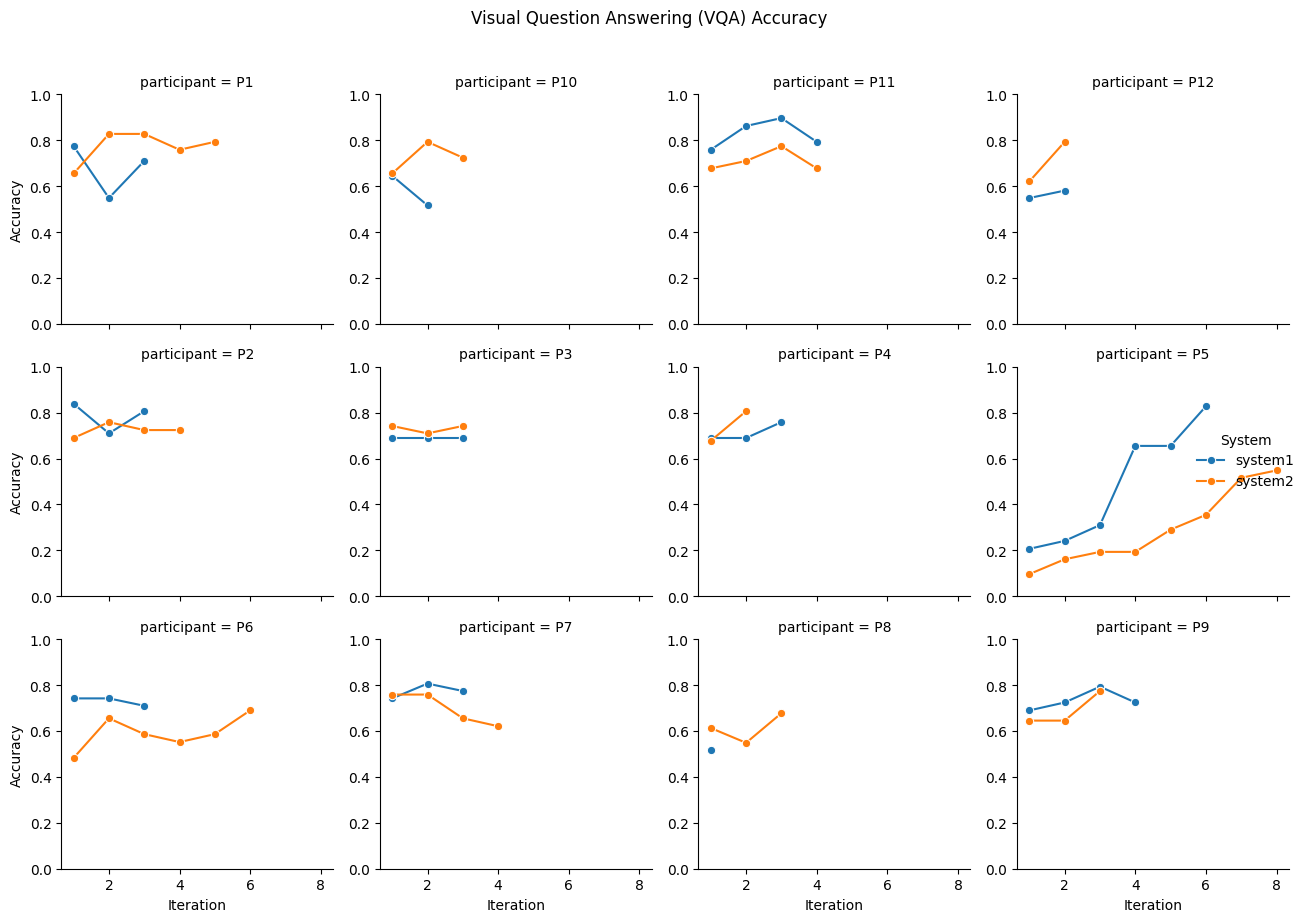

In [26]:
# participant/system별로 row 순서대로 iteration 번호 부여 후, SSIM/rating 변화 시각화
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('result/vqa/agg_per_participant_system_image.csv')

# participant,system,image_path,target_image_id,rating,total,correct,accuracy

# 각 participant/system별로 순서대로 iteration 번호 부여
df['iteration'] = df.groupby(['participant', 'system']).cumcount() + 1

# 1. SSIM 변화: participant별, system별, iteration별
g = sns.FacetGrid(
    df, col='participant', hue='system',
    col_wrap=4, height=3, sharey=False,
    palette={'system1':'#1f77b4','system2':'#ff7f0e'}
)
g.map(sns.lineplot, 'iteration', 'accuracy', marker='o')
g.add_legend(title='System')
g.set_axis_labels('Iteration', 'Accuracy')
g.set(ylim=(0,1))   # ✅ Accuracy 범위 0–1로 고정
g.fig.suptitle('Visual Question Answering (VQA) Accuracy', y=1.02)
plt.tight_layout()
plt.show()

In [36]:
import pandas as pd

PATH = "result/vqa/detailed_per_image_question.csv"
df = pd.read_csv(PATH)

# 예시: 한 명 참가자만 선택
pid = "P5"
df_sub = df[df["participant"] == pid].copy()
df_sub = df_sub[df_sub["system"] == "system2"].copy()

# iteration 번호 부여 (참가자 × system × question 순서대로)
df_sub["iteration"] = df_sub.groupby(["system", "question"]).cumcount() + 1

# Pivot: question × iteration (is_correct 값)
pivot = df_sub.pivot_table(
    index="question",
    columns="iteration",
    values="is_correct",
    aggfunc="first"  # 동일한 (question, iteration)에 여러 행 있으면 첫 값 사용
)

pivot

iteration,1,2,3,4,5,6,7,8
question,,,,,,,,
Are the group members generally arranged side by side?,False,False,False,False,False,False,False,True
Are there four people standing together in the scene?,False,False,False,False,False,False,True,True
Does her pose suggest excitement and attentiveness about documenting the trip?,False,False,False,False,False,False,True,True
"Does his posture appear attentive, like a planner or leader?",False,False,False,False,False,False,True,True
Does the man in the green shirt have a neutral expression?,False,True,False,False,False,True,False,True
Is he holding a large unfolded travel map?,False,False,False,False,False,False,False,False
"Is he looking to the side, scanning the surroundings?",False,False,False,False,False,False,True,True
Is he wearing sunglasses?,False,False,False,False,False,False,False,False
Is the man in the green shirt standing casually with his hands in his pockets?,False,False,False,False,False,True,False,False


In [ ]:
# Is the woman smiling?
# Are the adults smiling while the girl looks more serious?
# Does the girl look more serious or thoughtful than the adults?	
# Does the man have a neutral, purposeful expression?
# Does the man in the green shirt have a neutral expression?
# Are the group members generally arranged side by side?
# Is the man in the green shirt walking in a laid-back manner?	

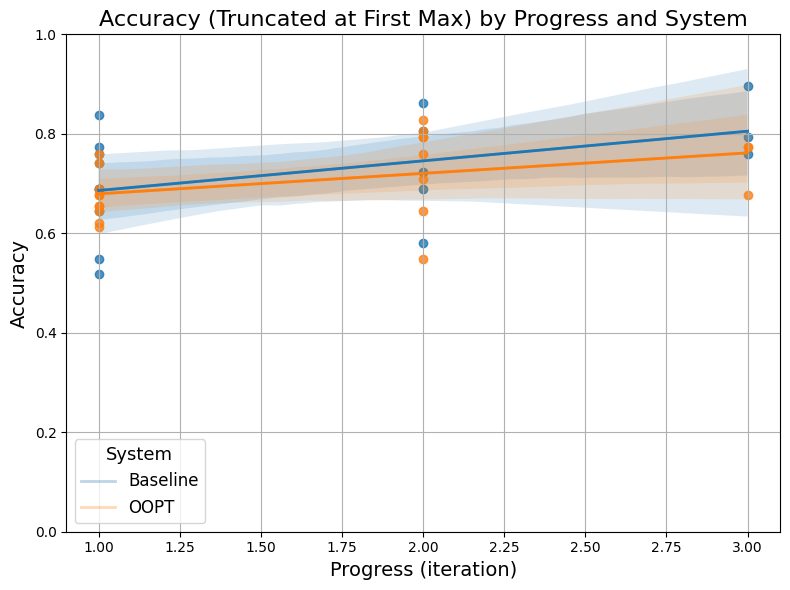

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PATH = "result/vqa/detailed_per_image_question.csv"
raw = pd.read_csv(PATH)

# raw = raw[~(raw["participant"] == "P5") & ~(raw["participant"] == "P6")]

# 1) 이미지 단위 accuracy 집계
img_acc = (
    raw.groupby(["participant", "system", "image_path"], sort=False)["is_correct"]
       .agg(total="count", correct="sum")
       .reset_index()
)
img_acc["accuracy"] = img_acc["correct"] / img_acc["total"]

# 2) 생성 순서 결정 (gen_index / timestamp 있으면 사용, 없으면 등장 순서)
order_col = None
for cand in ["gen_index", "image_timestamp", "created_at", "timestamp"]:
    if cand in raw.columns:
        order_col = cand
        break

if order_col is not None:
    order_rep = (
        raw.drop_duplicates(["participant","system","image_path"])
           [["participant","system","image_path", order_col]]
    )
    img_acc = img_acc.merge(order_rep, on=["participant","system","image_path"], how="left")
else:
    img_acc["gen_index"] = (
        img_acc.groupby(["participant","system"], sort=False)
               .cumcount() + 1
    )
    order_col = "gen_index"

# 3) 각 그룹별로 '최대 accuracy 첫 등장 시점까지' 자르기
def build_progress_df_until_max(img_df, participant_col="participant", system_col="system",
                                acc_col="accuracy", order_col="gen_index"):
    rows = []
    for (pid, sys_name), sub in img_df.groupby([participant_col, system_col], sort=False):
        sub = sub.copy()
        sub = sub.sort_values(by=order_col, kind="stable")
        accs = sub[acc_col].tolist()
        if len(accs) == 0:
            continue
        max_idx = int(np.argmax(accs))  # 첫 최대값 위치
        accs = accs[:max_idx+1]         # 그 시점까지만 사용
        for i, acc in enumerate(accs, start=1):
            rows.append({"participant": pid, "system": sys_name,
                         "progress": i, "accuracy": acc})
    return pd.DataFrame(rows)

df_viz = build_progress_df_until_max(img_acc, order_col=order_col)

# 4) 시각화
plt.figure(figsize=(8, 6))

palette = {"Baseline": "#1f77b4", "OOPT": "#ff7f0e"}
name_map = {"system1": "Baseline", "system2": "OOPT"}

for raw_sys, pretty_name in name_map.items():
    color = palette[pretty_name]
    sub = df_viz[df_viz["system"] == raw_sys]

    # 바깥 99.5% CI
    sns.regplot(
        data=sub, x="progress", y="accuracy", scatter=False,
        ci=99.5,
        line_kws={"lw": 2, "alpha": 0.30, "color": color},
        color=color, label=pretty_name
    )
    # 안쪽 95% CI
    sns.regplot(
        data=sub, x="progress", y="accuracy", scatter=True,
        ci=95,
        line_kws={"lw": 2, "alpha": 1.00, "color": color},
        color=color
    )

plt.title("Accuracy (Truncated at First Max) by Progress and System", fontsize=16)
plt.xlabel("Progress (iteration)", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(title="System", fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()
